# Home Is Where The Hearth Is
---

## Project Goals
- Create create a model that predicts single-unit values which the tax district assesses using the property data from those with a transaction during the months of May through August ("Hot Months").

- each state and county the properties are located in

- distribution of tax rates for each county

- distribution of tax rates for each county to show variance of properties within a given county

- rates the bulk of the properties sit around

In [1]:
import os
from env import host, user, password

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split

import sklearn.preprocessing
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import acquire as a
import prepare as p
import explore as e
import model as m

## Acquire

In [2]:
df = a.get_zillow_data()

In [3]:
df.head()

,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,266.0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,...,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04,Condominium
1,261.0,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21,Single Family Residential
2,261.0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,...,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23,Single Family Residential
3,266.0,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,...,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28,Condominium
4,261.0,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,...,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30,Single Family Residential


In [4]:
df.shape

(38598, 63)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38598 entries, 0 to 38597
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         38598 non-null  float64
 1   parcelid                      38598 non-null  int64  
 2   id                            38598 non-null  int64  
 3   airconditioningtypeid         12222 non-null  float64
 4   architecturalstyletypeid      101 non-null    float64
 5   basementsqft                  27 non-null     float64
 6   bathroomcnt                   38598 non-null  float64
 7   bedroomcnt                    38598 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         23698 non-null  float64
 10  calculatedbathnbr             38455 non-null  float64
 11  decktypeid                    333 non-null    float64
 12  finishedfloor1squarefeet      3339 non-null   float64
 13  c

In [6]:
df.isnull().sum()

propertylandusetypeid           0
parcelid                        0
id                              0
airconditioningtypeid       26376
architecturalstyletypeid    38497
                            ...  
censustractandblock           141
id.1                            0
logerror                        0
transactiondate                 0
propertylandusedesc             0
Length: 63, dtype: int64

#### Acquire takeaways

- There are a lot of missing values

- Need to find quantitative columns to scale for modeling

- With over 60 columns, most will be dropped

## Prepare

In [7]:
df = p.clean_zillow(df)

In [8]:
df.head()

,bath,bed,sqft,fips,fireplaces,garagecarcnt,lot_sqft,pool,rooms,three_qtr_bath,year,tax_value,taxamount
0,2.0,3,1125.0,6059,0,1,29630.897223,0,6,0,1974,289445.0,3490.16
1,2.0,3,1316.0,6037,0,0,5672.000000,0,0,0,1923,205123.0,2627.48
2,2.0,3,1458.0,6037,0,0,8284.000000,1,0,0,1970,136104.0,2319.90
3,2.0,3,1766.0,6037,0,0,25082.000000,0,0,0,1980,810694.0,9407.01
4,1.0,2,1421.0,6037,0,0,6707.000000,0,0,0,1911,35606.0,543.69


In [9]:
df.shape, \
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37124 entries, 0 to 38563
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bath            37124 non-null  float64
 1   bed             37124 non-null  int64  
 2   sqft            37124 non-null  float64
 3   fips            37124 non-null  int64  
 4   fireplaces      37124 non-null  int64  
 5   garagecarcnt    37124 non-null  int64  
 6   lot_sqft        37124 non-null  float64
 7   pool            37124 non-null  int64  
 8   rooms           37124 non-null  int64  
 9   three_qtr_bath  37124 non-null  int64  
 10  year            37124 non-null  int64  
 11  tax_value       37124 non-null  float64
 12  taxamount       37124 non-null  float64
dtypes: float64(5), int64(8)
memory usage: 4.0 MB


((37124, 13), None)

<AxesSubplot:xlabel='tax_value', ylabel='Count'>

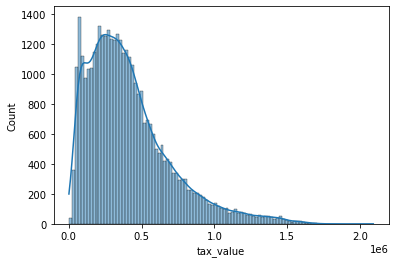

In [10]:
sns.histplot(df.tax_value, kde=True)

In [11]:
train, validate, test = p.split_data(df)

In [12]:
train.shape, validate.shape, test.shape

((26728, 13), (6683, 13), (3713, 13))

In [13]:
X_train, y_train, X_validate, y_validate, X_test, y_test = p.X_y_split(train, validate, test, 'tax_value')

In [14]:
X_train.shape, y_train.shape, X_validate.shape, y_validate.shape, X_test.shape, y_test.shape

((26728, 12), (26728,), (6683, 12), (6683,), (3713, 12), (3713,))

In [15]:
cats = ['fips']
quants = ['bath', 'bed', 'sqft', 'garagecarcnt', 'lot_sqft', 'rooms', 'three_qtr_bath', 'year', 'pool', 'fireplaces']
target = 'tax_value'

In [16]:
X_train_scaled, X_validate_scaled, X_test_scaled = p.minmax_scaler(X_train, X_validate, X_test, quants)
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((26728, 10), (6683, 10), (3713, 10))

#### Prepare takeaways

- We lost less than 3,000 rows after data prep

- We also lost almost 50 columns
    - Most useless or gave redundant data

### Data Dictionary
- year: The Year the principal residence was built
- fips: Federal Information Processing Standard code
- sqft: Calculated total finished living area of the home
- lot_sqft: Area of the lot in square feet
- three_qtr_bath: Number of 3/4 bathrooms in house (shower + sink + toilet)
- bath: Number of bathrooms in home including fractional bathrooms
- bed: Number of bedrooms in home
- fireplaces: Number of fireplaces in a home (if any)
- garagecarcnt: Total number of garages on the lot including an attached garage
- pool: Number of pools on the lot (if any)
- rooms: Total number of rooms in the principal residence
- taxamount: The total property tax assessed for that assessment year
- tax_value: The total tax assessed value of the parcel

## Explore

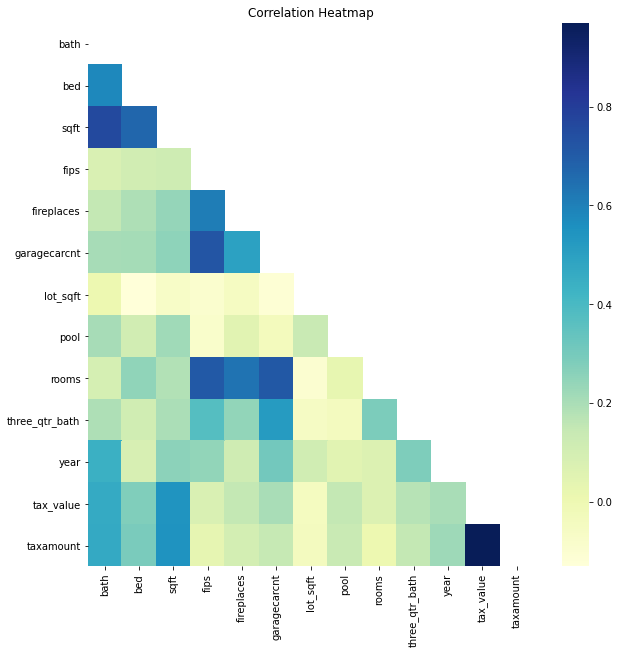

In [18]:
e.get_hot(train)

## Initial Hypotheses

---
### Hypothesis 1:

#### Set Hypothesis

$H_{0}$: Mean tax_value of lot_sqft in top 25% <= Mean tax_value of lot_sqft in bottom 25% 

$H_{a}$: Mean tax_value of lot_sqft in top 25% > Mean tax_value of lot_sqft in bottom 25% 

#### Visualize

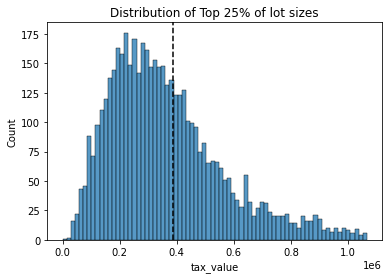

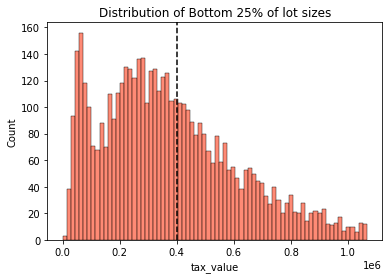

In [19]:
top_lot_tax_value = train[train.lot_sqft > train.lot_sqft.quantile(.75)].tax_value
top_mean = top_lot_tax_value.mean()
bot_lot_tax_value = train[train.lot_sqft < train.lot_sqft.quantile(.25)].tax_value
bot_mean = bot_lot_tax_value.mean()

bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*round(df.tax_value.std(), 2))
    
plt.title('Distribution of Top 25% of lot sizes')
sns.histplot(top_lot_tax_value.head(5000), bins=bins)
plt.axvline(top_mean, color='black', linestyle='--')
plt.show()

plt.title('Distribution of Bottom 25% of lot sizes')
sns.histplot(bot_lot_tax_value.head(5000), bins=bins, color='tomato')
plt.axvline(bot_mean, color='black', linestyle='--')
plt.show()

#### Set Alpha

$\alpha$ = 0.5

In [20]:
a = 0.05

**T-test: 2-Sample**

In [21]:
t, p = stats.ttest_ind(top_lot_tax_value, bot_lot_tax_value, equal_var = False)
t, p/2

print("is p/2 < alpha? ", p/2 < a)
print("is t > 0? ", t > 0)
if p/2 > a:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p/2 < alpha?  True
is t > 0?  False
We fail to reject $H_{0}$


Therefore, on average, lot sizes in the bottom 25% of total area have property values greater than or equal to lots that are in the top 25%.
___

### Hypothesis 2:

#### Set Hypothesis

$H_{0}$: There is no linear correlation between year built and tax value.

$H_{a}$: There is a linear correlation between year built and tax value.

#### Visualize

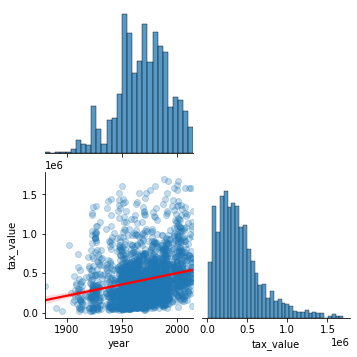

In [22]:
sns.pairplot(train[['year','tax_value']].sample(2_500), kind="reg", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': .25}}, corner=True)

#### Set Alpha

$\alpha$ = 0.5

In [23]:
a = 0.05

**Correlation Test: Pearsonr**

In [24]:
corr, p = stats.pearsonr(X_train.year, y_train)
corr, p

print("is p < alpha? ", p < a)
if p < a:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p < alpha?  True
We fail to reject $H_{0}$


Therefore, the year a property is built is not linearly correlated with tax value.

___

### Hypothesis 3:

#### Set Hypothesis

$H_{0}$: Mean tax value of houses with at least fireplace == Mean tax value of houses without a fireplace

$H_{a}$: Mean tax value of houses with at least fireplace != Mean tax value of houses without a fireplace 

#### Visualize

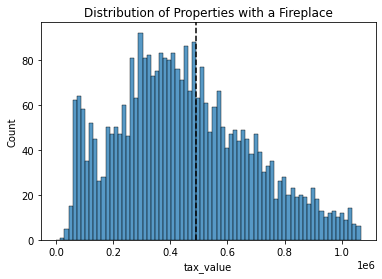

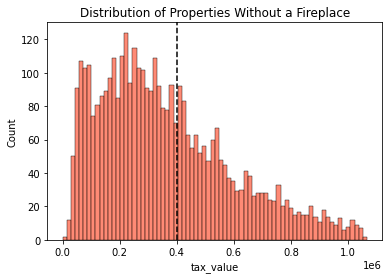

In [25]:
fire_tax_value = train[train.fireplaces > 0].tax_value
fire_mean = fire_tax_value.mean()
no_fire_tax_value = train[train.fireplaces == 0].tax_value
no_fire = no_fire_tax_value.mean()

bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*round(df.tax_value.std(), 2))
    
plt.title('Distribution of Properties with a Fireplace')
sns.histplot(fire_tax_value.head(4_000), bins=bins)
plt.axvline(fire_mean, color='black', linestyle='--')
plt.show()

plt.title('Distribution of Properties Without a Fireplace')
sns.histplot(no_fire_tax_value.head(4_000), bins=bins, color='tomato')
plt.axvline(no_fire, color='black', linestyle='--')
plt.show()

#### Set Alpha

$\alpha$ = 0.5

In [26]:
a = 0.05

**T-test: 2-Sample**

In [27]:
t, p = stats.ttest_ind(fire_tax_value, no_fire_tax_value, equal_var = False)
t, p/2

print("is p/2 < alpha? ", p/2 < a)
print("is t > 0? ", t > 0)
if p/2 > a:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p/2 < alpha?  True
is t > 0?  True
We reject $H_{0}$


Therefore, on average, fireplaces increase the tax value of a property.
___

### Hypothesis 4:

#### Set Hypothesis

$H_{0}$: Mean tax value of houses with pools == Mean tax value of houses without pools

$H_{a}$: Mean tax value of houses with pools != Mean tax value of houses without pools 

#### Visualize

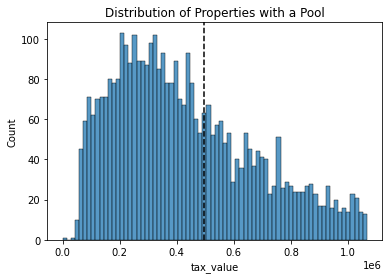

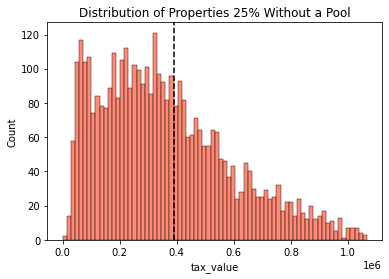

In [28]:
pool_tax_value = train[train.pool == 1].tax_value
pool_mean = pool_tax_value.mean()
no_pool_tax_value = train[train.pool == 0].tax_value
no_pool = no_pool_tax_value.mean()

bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*round(df.tax_value.std(), 2))
    
plt.title('Distribution of Properties with a Pool')
sns.histplot(pool_tax_value.head(4_000), bins=bins)
plt.axvline(pool_mean, color='black', linestyle='--')
plt.show()

plt.title('Distribution of Properties 25% Without a Pool')
sns.histplot(no_pool_tax_value.head(4_000), bins=bins, color='tomato')
plt.axvline(no_pool, color='black', linestyle='--')
plt.show()

#### Set Alpha

$\alpha$ = 0.5

In [29]:
a = 0.05

**T-test: 2-Sample**

In [30]:
t, p = stats.ttest_ind(pool_tax_value, no_pool_tax_value, equal_var = False)
t, p/2

print("is p/2 < alpha? ", p/2 < a)
print("is t > 0? ", t > 0)
if p/2 > a:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p/2 < alpha?  True
is t > 0?  True
We reject $H_{0}$


Therefore, on average, pools increase the tax value of a property.

#### Explore Takeaways
- Even if a plot has more square feet, that does not mean the property value will increase.

- Age does not have a strong correlation to property value

- Californians value fireplaces enough to pay more fore a property

- To go witht the fireplaces, people will pay more for pools, as well.

## Model

First, we choose a baseline model

In [31]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
mean_baseline = y_train['tax_value'].mean()
y_train['mean_baseline'] = mean_baseline
y_validate['mean_baseline'] = mean_baseline

#RMSE of tax_value_pred_mean
rmse_train_mean = mean_squared_error(y_train.tax_value, y_train.mean_baseline)**(1/2)
rmse_validate_mean = mean_squared_error(y_validate.tax_value, y_validate.mean_baseline)**(1/2)

#R^2 Score of mean
r2_baseline_mean = r2_score(y_validate.tax_value, y_validate.mean_baseline)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 2))
print(f'Mean: {r2_baseline_mean}')
print('----------------------------------')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  288912.28 
Validate/Out-of-Sample:  286782.32
Mean: -9.592961198512384e-06
----------------------------------


In [32]:
#tax_value_median
median_baseline = y_train['tax_value'].median()
y_train['median_baseline'] = median_baseline
y_validate['median_baseline'] = median_baseline

#RMSE of tax_value_pred_median
rmse_train_median = mean_squared_error(y_train.tax_value, y_train.median_baseline)**(1/2)
rmse_validate_median = mean_squared_error(y_validate.tax_value, y_validate.median_baseline)**(1/2)

#R^2 Score of median
r2_baseline_median = r2_score(y_validate.tax_value, y_validate.median_baseline)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_median, 2))
print(f'Median: {r2_baseline_median}')
print('----------------------------------')

             BASELINE
----------------------------------
RMSE using Median
Train/In-Sample:  295345.71 
Validate/Out-of-Sample:  293076.72
Median: -0.044388483826363734
----------------------------------


Mean performed a little better, so we choose mean as the baseline value.

In [33]:
# Get baseline model metrics to compare future models
SSE_baseline, ESS_baseline, TSS_baseline, MSE_baseline, RMSE_baseline = m.regression_errors(y_train, 'tax_value', 'mean_baseline')
df_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline', 'R2_baseline']), columns=['metric'])
df_baseline_eval['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline, r2_baseline_mean])
df_baseline_eval

,metric,baseline_error
0,SSE_baseline,2.230994e+15
1,MSE_baseline,8.347031e+10
2,RMSE_baseline,2.889123e+05
3,R2_baseline,-9.592961e-06


In [34]:
# Find best features to use for future models
X_kbest, X_rfe = m.k_best(X_train_scaled, 6, y_train.tax_value)
X_kbest, X_rfe

(Index(['bath', 'bed', 'sqft', 'garagecarcnt', 'three_qtr_bath', 'year'], dtype='object'),
 Index(['bath', 'bed', 'sqft', 'garagecarcnt', 'lot_sqft', 'rooms'], dtype='object'))

### OLS Regression

RMSE for OLS
Training/In-Sample:  236764.50537932495 
Validation/Out-of-Sample:  231736.89914982242


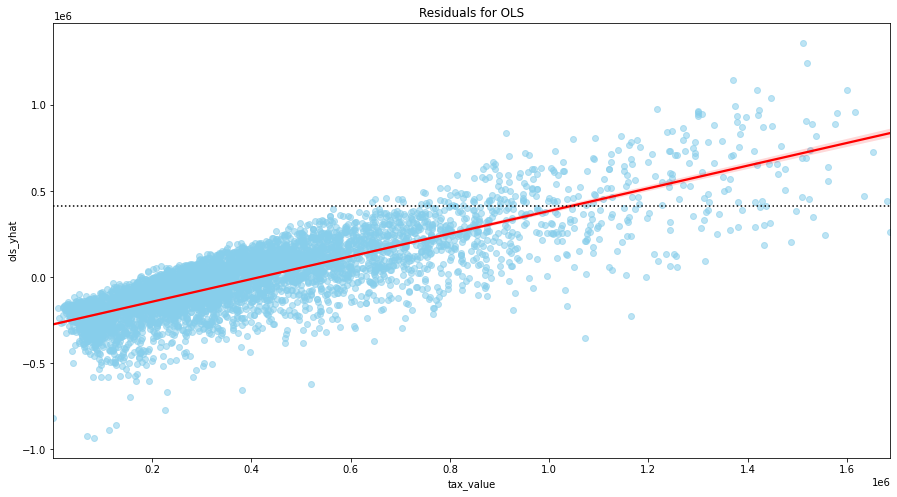

In [35]:
# create the model
ols = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
ols.fit(X_train_scaled[X_kbest], y_train['tax_value'])

# predict train
y_train['ols_yhat'] = ols.predict(X_train_scaled[X_kbest])

# evaluate: rmse
rmse_train = mean_squared_error(y_train['tax_value'], y_train['ols_yhat'])**(1/2)

# predict validate
y_validate['ols_yhat'] = ols.predict(X_validate_scaled[X_kbest])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['tax_value'], y_validate['ols_yhat'])**(1/2)

print("RMSE for OLS\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
m.plot_residuals(y_train.head(5_000), 'tax_value', 'ols_yhat', 'OLS')

In [36]:
# Compare OLS model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'tax_value', 'ols_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.tax_value, y_train.ols_yhat)])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = m.better_than_baseline(y_train, 'tax_value', 'ols_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,1.498303e+15,-7.326913e+14,True
1,MSE,5.605743e+10,-2.741288e+10,True
2,RMSE,2.367645e+05,-5.214778e+04,True
3,R2,3.284147e-01,3.284243e-01,True


### LassoLars Regression

RMSE for Lasso + Lars
Training/In-Sample:  236765.28231588218 
Validation/Out-of-Sample:  231729.61683636194


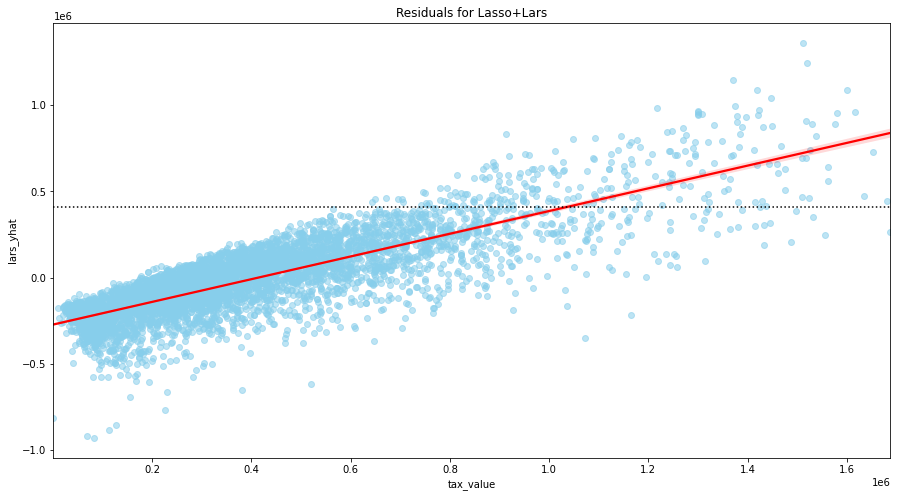

In [37]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[X_kbest], y_train['tax_value'])

# predict train
y_train['lars_yhat'] = lars.predict(X_train_scaled[X_kbest])

# evaluate: rmse
rmse_train = mean_squared_error(y_train['tax_value'], y_train['lars_yhat'])**(1/2)

# predict validate
y_validate['lars_yhat'] = lars.predict(X_validate_scaled[X_kbest])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['tax_value'], y_validate['lars_yhat'])**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
m.plot_residuals(y_train.head(5_000), 'tax_value', 'lars_yhat', 'Lasso+Lars')

In [38]:
# Compare Lasso+Lars model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'tax_value', 'lars_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.tax_value, y_train.lars_yhat)])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = m.better_than_baseline(y_train, 'tax_value', 'lars_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,1.498313e+15,-7.326815e+14,True
1,MSE,5.605780e+10,-2.741251e+10,True
2,RMSE,2.367653e+05,-5.214700e+04,True
3,R2,3.284103e-01,3.284199e-01,True


### TweedieRegressor (GLM) Regression

RMSE for GLM, power=1 & alpha=1
Training/In-Sample:  244565.62720521042 
Validation/Out-of-Sample:  242292.74796438302


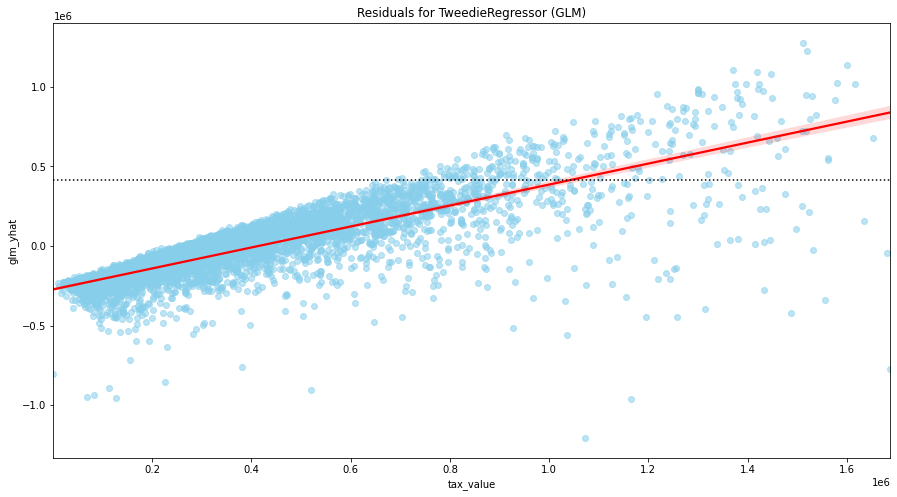

In [39]:
# create the model object
glm = TweedieRegressor(power=1, alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[X_kbest], y_train['tax_value'])

# predict train
y_train['glm_yhat'] = glm.predict(X_train_scaled[X_kbest])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.glm_yhat)**(1/2)

# predict validate
y_validate['glm_yhat'] = glm.predict(X_validate_scaled[X_kbest])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.glm_yhat)**(1/2)

print("RMSE for GLM, power=1 & alpha=1\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
m.plot_residuals(y_train.head(5_000), 'tax_value', 'glm_yhat', 'TweedieRegressor (GLM)')

In [40]:
# Compare GLM model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'tax_value', 'glm_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.tax_value, y_train.glm_yhat)])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = m.better_than_baseline(y_train, 'tax_value', 'glm_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,1.598664e+15,-6.323300e+14,True
1,MSE,5.981235e+10,-2.365796e+10,True
2,RMSE,2.445656e+05,-4.434666e+04,True
3,R2,2.834297e-01,2.834393e-01,True


###  Polynomial Regression

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  229825.7560579643 
Validation/Out-of-Sample:  227202.60662807155


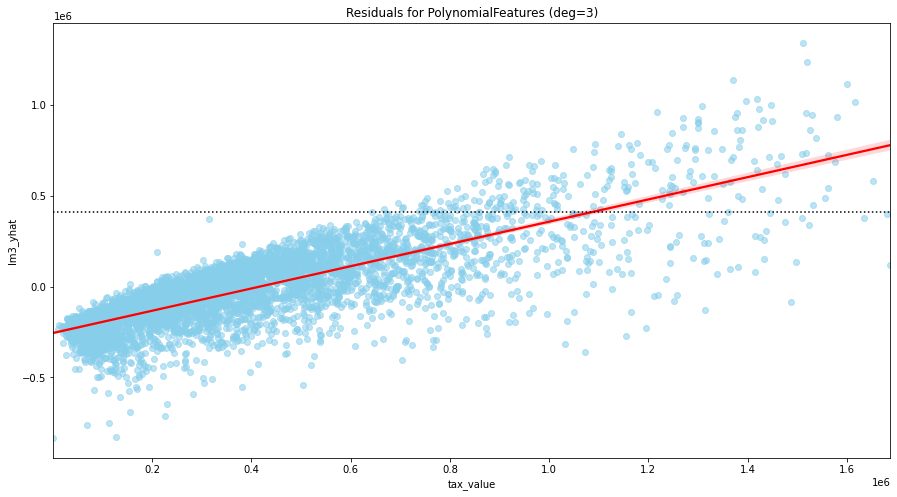

In [41]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[X_kbest])

# transform X_validate_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[X_kbest])

# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['lm3_yhat'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lm3_yhat)**(1/2)

# predict validate
y_validate['lm3_yhat'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lm3_yhat)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)
m.plot_residuals(y_train.head(5_000), 'tax_value', 'lm3_yhat', 'PolynomialFeatures (deg=3)')

In [42]:
# Compare Polynomial (deg=3) model metrics to baseline
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_train, 'tax_value', 'lm3_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])
df_eval['model_error'] = np.array([SSE, MSE, RMSE, r2_score(y_train.tax_value, y_train.lm3_yhat)])
df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = m.better_than_baseline(y_train, 'tax_value', 'lm3_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,1.411770e+15,-8.192247e+14,True
1,MSE,5.281988e+10,-3.065043e+10,True
2,RMSE,2.298258e+05,-5.908653e+04,True
3,R2,3.672016e-01,3.672112e-01,True


#### Takeaways
- I selected the mean baseline model since it performed better than the median baseline

- Using SelectKBEst, I found the 6 best features from the scaled X_train data

- OLS model was a little overfit with an R2 of 0.238

- Lasso + Lars performed nearly identically to the OLS model

- GLM and Polynomial Regression were the least overfit of all models
    - Polynomial Regression had the best R2 score of .367

- I will use Polynomial Regression on the Out-of-Sample data

### Test

In [43]:
y_test = pd.DataFrame(y_test)

X_test_degree3 =  pf.fit_transform(X_test_scaled[X_kbest])

lm3.fit(X_test_degree3, y_test.tax_value)

# predict on test
y_test['lm3_yhat'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.lm3_yhat) ** (1/2)

print("RMSE for Polynomial Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Polynomial Model using LinearRegression
Out-of-Sample Performance:  224080.88795744837


In [44]:
SSE, ESS, TSS, MSE, RMSE = m.regression_errors(y_test, 'tax_value', 'lm3_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE, r2_score(y_test.tax_value, y_test.lm3_yhat)])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = m.better_than_baseline(y_test, 'tax_value', 'lm3_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,1.864381e+14,-2.044556e+15,True
1,MSE,5.021224e+10,-3.325806e+10,True
2,RMSE,2.240809e+05,-6.483139e+04,True
3,R2,3.824469e-01,3.824565e-01,True


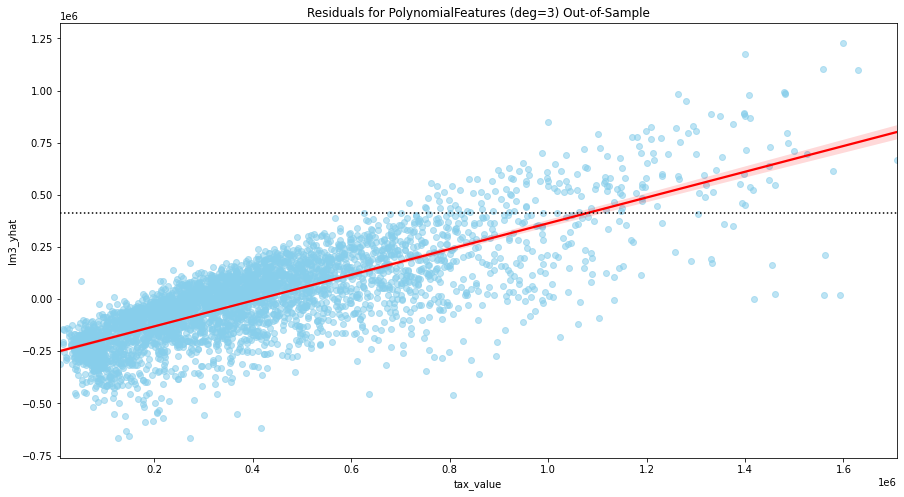

In [45]:
m.plot_residuals(y_test.head(5_000), 'tax_value', 'lm3_yhat', 'PolynomialFeatures (deg=3) Out-of-Sample')

---
## Tax Rates per County

Now we work with each county:
#### FIPS codes:
|Fips code| County|
|---|---|
|6037 | Los Angeles County|
|6059 | Orange County|
|6111 | Ventura County|

In [46]:
df.fips.value_counts()

6037    23019
6059    10712
6111     3393
Name: fips, dtype: int64

In [47]:
# create tax rate columns as taxamount / tax_value
df['tax_rate'] = df.taxamount / df.tax_value

In [48]:
oc = df[df.fips==6059].tax_rate.mean()
vc = df[df.fips==6111].tax_rate.mean()
lac = df[df.fips==6037].tax_rate.mean()
oc * 100, vc * 100, lac * 100

(1.2046691529917335, 1.1877382491534065, 1.379311021233463)

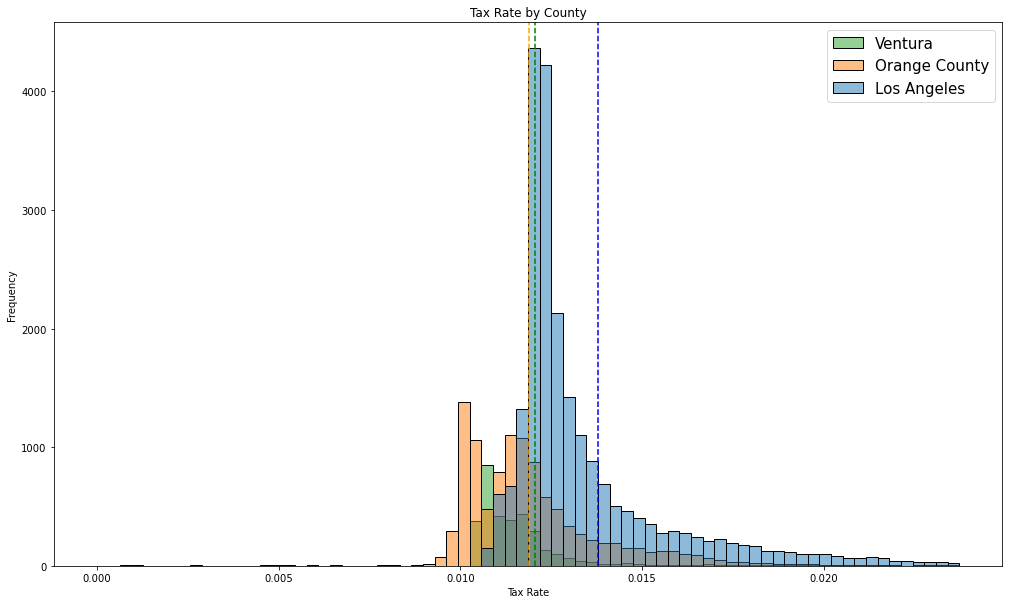

In [49]:
#Create bins for the graph
bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*df.tax_rate.std())

plt.figure(figsize=(17,10))
sns.histplot(data=df, x=df.tax_rate, bins=bins, hue=df.fips, palette='tab10')

plt.title('Tax Rate by County')
plt.xlabel('Tax Rate')
plt.ylabel('Frequency')
plt.legend(['Ventura', 'Orange County', 'Los Angeles'])

plt.legend(['Ventura', 'Orange County', 'Los Angeles'], fontsize=15)

plt.axvline(df[df.fips==6059].tax_rate.mean(), color='green', linestyle='--')
plt.axvline(df[df.fips==6111].tax_rate.mean(), color='orange', linestyle='--')
plt.axvline(df[df.fips==6037].tax_rate.mean(), color='blue', linestyle='--')

---

## Conclusions
- Square feet of the unit is the best predictor of property value
- Amenitites like pools fireplaces can also help predict value, but not as strongly as sqft, bath count, or bed count
- Age of home was as strong correlation as a predictor as i anticipated
- County was not as strong of a predictor as i had anticipated
- Multi-car garages 

## If I had more time...
- I would determine if zoning plays a role in value

- I would have liked to find specific zip codes for the units

- I would like to see if age of buyer plays a major role in property value